In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [ ]:
''' Activation Functions '''

def relu(x, p=False):
    if p: return 1 * (x > 0)
    return x * (x > 0)

def linear(x, p=False):
    if p: return np.ones_like(x)
    return x

In [ ]:
''' Cost Functions '''

def MSE(output_acts, y, p=False):
    if p: return (output_acts-y)
    return 0.5*(output_acts-y)**2

def MAE(output_acts, y, p=False):
    if p: return np.sign(output_acts-y) #zero ??
    return np.abs(output_acts-y)

def logcosh(output_acts, y, p=False):
    error = (output_acts-y)
    if p: return np.sinh(error) / np.cosh(error)
    return np.log(np.cosh(error))

def huber(output_acts, y, delta=1.0, p=False):
    huber_mse = MSE(output_acts, y, p)
    huber_mae = delta * (MAE(output_acts, y, p) - (0.5 * delta)*(not p)) # delta*(+-1)
    return np.where(np.abs(output_acts - y) <= delta, huber_mse, huber_mae)

In [ ]:
''' Optimizer Class '''

class Optimizer:

    def __init__(self, name, args):
        self.name = name
        self.args = args
        self.eps = 1e-8
        self.lr = 0

    def initialize(self, vars):
        if self.name in 'sgd':
            self.momentum = [np.zeros(v.shape) for v in vars]
        
        if self.name == 'adagrad':
            self.second_moment = [np.zeros(v.shape) for v in vars]

        if self.name == 'rmsprop':
            self.second_moment = [np.zeros(v.shape) for v in vars]

        if self.name == 'adadelta':
            self.second_moment = [np.zeros(v.shape) for v in vars]
            self.second_moment_updates = [np.zeros(v.shape) for v in vars]

        if self.name == 'adam':
            self.t = 1 
            self.first_moment = [np.zeros(v.shape) for v in vars]
            self.second_moment = [np.zeros(v.shape) for v in vars]
        
    def set_lr(self, lr):
        self.lr = lr

    def update(self, var, nabla):
        if self.name == 'sgd':
            alpha = self.args['alpha']
            self.momentum = [alpha*m + self.lr*n 
                            for m, n in zip(self.momentum, nabla)]
            var = [v - m for v, m in zip(var, self.momentum)]

        elif self.name == 'adagrad':
            self.second_moment = [g + n**2 
                                  for g, n in zip(self.second_moment, nabla)]
            var = [v - (n*self.lr)/(np.sqrt(g) + self.eps)
                    for v, n, g in zip(var, nabla, self.second_moment)]                      

        elif self.name == 'rmsprop':
            decay_rate = self.args['decay_rate']
            self.second_moment = [decay_rate * m + (1-decay_rate) * (n**2)
                                  for m, n in zip(self.second_moment, nabla)]
            var = [v - (n*self.lr)/(np.sqrt(g) + self.eps)
                    for v, n, g in zip(var, nabla, self.second_moment)] 
        
        elif self.name == 'adadelta':
            decay_rate = self.args['decay_rate']
            self.second_moment = [decay_rate * m + (1-decay_rate) * (n**2)
                                  for m, n in zip(self.second_moment, nabla)]
            updates = [((np.sqrt(u) + self.eps)*n)/(np.sqrt(g) + self.eps)
                    for n, u, g in zip(nabla, self.second_moment_updates, self.second_moment)]
            var = [v - u for v, u in zip(var, updates)]
            self.second_moment_updates = [decay_rate * m + (1-decay_rate) * (u**2)
                                          for m, u in zip(self.second_moment_updates, updates)]

        elif self.name == 'adam':
            beta1 = self.args['beta1']
            beta2 = self.args['beta2']
            self.t += 1
            self.first_moment = [beta1 * m + (1-beta1) * n
                                  for m, n in zip(self.first_moment, nabla)]
            self.second_moment = [beta2 * m + (1-beta2) * (n**2)
                                  for m, n in zip(self.second_moment, nabla)]
            fm_hat = [m/(1-(beta1**self.t)) for m in self.first_moment]
            sm_hat = [m/(1-(beta2**self.t)) for m in self.second_moment]
            var = [v - (m*self.lr)/(np.sqrt(g) + self.eps)
                    for v, m, g in zip(var, fm_hat, sm_hat)]

        return var

In [ ]:
''' Learning Rate Schedulers '''

def constant(lr, epoch):
    return lr

def time_decay(lr, epoch, decay_rate):
    return lr / (1. + decay_rate*epoch)

def exp_decay(lr, epoch, decay_rate):
    return lr * np.exp(-epoch*decay_rate)

def step_decay(lr, epoch, decay_rate, decay_step):
    return lr * decay_rate**(np.floor(epoch/decay_step))

In [ ]:
''' Network Class '''

class Network:

    def __init__(self, s=43):
        np.random.seed(s)
        self.layer_cnt = 0
        self.weights = []
        self.biases = []
        self.act_funcs = []
        self.keep_props = []
        self.report = dict()
        self.report['train_loss'] = []
        self.report['train_re'] = []
        self.report['test_loss'] = []
        self.report['test_re'] = []

    def dense(self, neuron_cnt, act_func, input_shape=None):
        if self.layer_cnt == 0 and (not input_shape):
            raise Exception('First Layer Must Have Input Shape')

        self.layer_cnt += 1

        if self.layer_cnt == 1:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, input_shape)))
        else:
            self.weights.append(np.random.normal(0, 0.05, (neuron_cnt, self.weights[-1].shape[0])))

        self.biases.append(np.zeros((neuron_cnt, 1)))
        self.act_funcs.append(act_func)
        self.keep_props.append(1.0)
    
    def dropout(self, keep_prop=0.5):
        self.keep_props[-1] = keep_prop

    def feedforward(self, x, test=False):
        pre_acts, acts = [], []
        act = np.array(x)

        acts.append(act)

        for w, b, a, p in zip(self.weights, self.biases,
                              self.act_funcs, self.keep_props):
            pre_act = np.dot(w, act) + b
            act = a(pre_act)
            pre_acts.append(pre_act)
            if test:
                act *= p
            else:
                act *= np.random.binomial(1, p, act.shape)
            acts.append(act)

        return pre_acts, acts, act

    def backprop(self, x, y, cost_func):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        pre_acts, acts, out = self.feedforward(x)

        delta = cost_func(acts[-1], y, p=True) * self.act_funcs[-1](pre_acts[-1], p=True)
        nabla_w[-1] = np.dot(delta, acts[-2].T)
        nabla_b[-1] = delta

        for i in range(2, self.layer_cnt+1):
            delta = np.dot(self.weights[-i+1].T, delta) * self.act_funcs[-i](pre_acts[-i], p=True)
            nabla_w[-i] = np.dot(delta, acts[-i-1].T)
            nabla_b[-i] = delta

        return nabla_w, nabla_b, out

    def next_mini_batch(self, dataset, batch_size):
        N = dataset['count']
        indxs = np.arange(N)
        np.random.shuffle(indxs)

        for i in range(0, N-batch_size+1, batch_size):
            mini_batch = indxs[i:i+batch_size]
            yield zip(dataset['X'][mini_batch], dataset['y'][mini_batch])

    def test(self, cost_func, testdata):
        y_, y_h = [], []
        
        for x, y in zip(testdata['X'], testdata['y']):
            _, _, out = self.feedforward(x, test=True)
            y_.append(y)
            y_h.append(out)

        y_, y_h = np.array(y_).ravel(), np.array(y_h).ravel()
        self.report['test_loss'].append(np.mean(cost_func(y_h, y_)))
        self.report['test_re'].append(np.mean(np.abs((y_h-y_)/y_)))

    def learn(self, cost_func, epochs, dataset, reg=None,
            opt_args=None, lr_schedulers=None, nasterov=False,
            eta=0.001, alpha=0.9, batch_size=32, verbos=1):
        
        if not opt_args:
            opt_args = ('adam', {'beta1':0.9, 'beta2':0.999})

        if not lr_schedulers:
            lr_schedulers = lambda lr, epoch: constant(lr, epoch)
        
        optimizer_b = Optimizer(*opt_args)
        optimizer_w = Optimizer(*opt_args)
        optimizer_b.initialize(self.biases)
        optimizer_w.initialize(self.weights)

        test_count = int(dataset['count']*dataset['split'])
        train_count = dataset['count'] - test_count
        test_data = {'count':test_count,
                    'X': dataset['X'][-test_count:],
                    'y': dataset['y'][-test_count:]}
        train_data = {'count':train_count,
                    'X': dataset['X'][:train_count],
                    'y': dataset['y'][:train_count]}

        for i in tqdm(range(epochs), disable=(not verbos)):
            eta_ = lr_schedulers(eta, i)
            lr = eta_/batch_size
            optimizer_b.set_lr(lr)
            optimizer_w.set_lr(lr)

            y_, y_h = [], []

            for mini_batch in self.next_mini_batch(train_data, batch_size):
                nabla_b = [np.zeros(b.shape) for b in self.biases]
                nabla_w = [np.zeros(w.shape) for w in self.weights]

                if nasterov:
                    self.biases = [b + alpha*m 
                                   for b, m in zip(self.biases, optimizer_b.momentum)]
                    self.weights = [w + alpha*m 
                                    for w, m in zip(self.weights, optimizer_w.momentum)]

                for x, y in mini_batch:
                    delta_nabla_w, delta_nabla_b, out = self.backprop(x, y, cost_func)
                    nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)] 
                    nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
                    y_.append(y)
                    y_h.append(out)

                if reg:
                    if reg['mode']=='L1':
                        self.weights = [w - np.sign(w)*(eta_*reg['lambda']/train_count)
                                        for w in self.weights] 
                    if reg['mode']=='L2':
                        self.weights = [w * (1-(eta_*reg['lambda']/train_count))
                                        for w in self.weights]

                self.biases = optimizer_b.update(self.biases, nabla_b)
                self.weights =  optimizer_w.update(self.weights, nabla_w)

            y_, y_h = np.array(y_).ravel(), np.array(y_h).ravel()
            self.report['train_loss'].append(np.mean(cost_func(y_h, y_)))
            self.report['train_re'].append(np.mean(np.abs((y_h-y_)/y_)))

            self.test(cost_func, test_data)

            if verbos == 1:
                print("train loss:{} test loss:{}" 
                      .format(self.report['train_loss'][-1], 
                              self.report['test_loss'][-1]))

    def reset(self):
        self.biases = [np.random.rand(*b.shape) for b in self.biases]
        self.weights = [np.random.rand(*w.shape) for w in self.weights]
        self.report['train_loss'] = []
        self.report['train_re'] = []
        self.report['test_loss'] = []
        self.report['test_re'] = []

In [ ]:
''' Dataset Functions '''

def make_dataset():
    dataset_path = "/content/drive/My Drive/cancer_reg.csv"
    dataset = pd.read_csv(dataset_path, na_values = "",
                        sep=",", skipinitialspace=True,
                        encoding='latin-1')
    dataset = dataset[['TARGET_deathRate','avgAnnCount','avgDeathsPerYear',
                    'incidenceRate','popEst2015', 'povertyPercent',
                    'studyPerCap', 'MedianAge', 'MedianAgeMale',
                    'MedianAgeFemale', 'AvgHouseholdSize',
                    'PercentMarried', 'PctNoHS18_24', 'PctHS18_24',
                    'PctBachDeg18_24', 'PctHS25_Over', 'PctPrivateCoverage',
                    'PctEmpPrivCoverage', 'PctPublicCoverageAlone',
                    'PctWhite', 'PctBlack', 'PctAsian',
                    'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate']]
    dataset = dataset.dropna()
    dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    y = dataset.pop('TARGET_deathRate')
    X = dataset
    train_stats = dataset.describe()
    train_stats = train_stats.transpose()
    X = (X - train_stats['mean']) / train_stats['std']

    mydata = dict()
    mydata['count'], mydata['split'] = 1000, 0.3
    mydata['X'] = X.to_numpy().reshape(-1, 24, 1)
    mydata['y'] = y.to_numpy().reshape(-1, 1, 1)

    return mydata

20.92074481936391 14.48625840279653


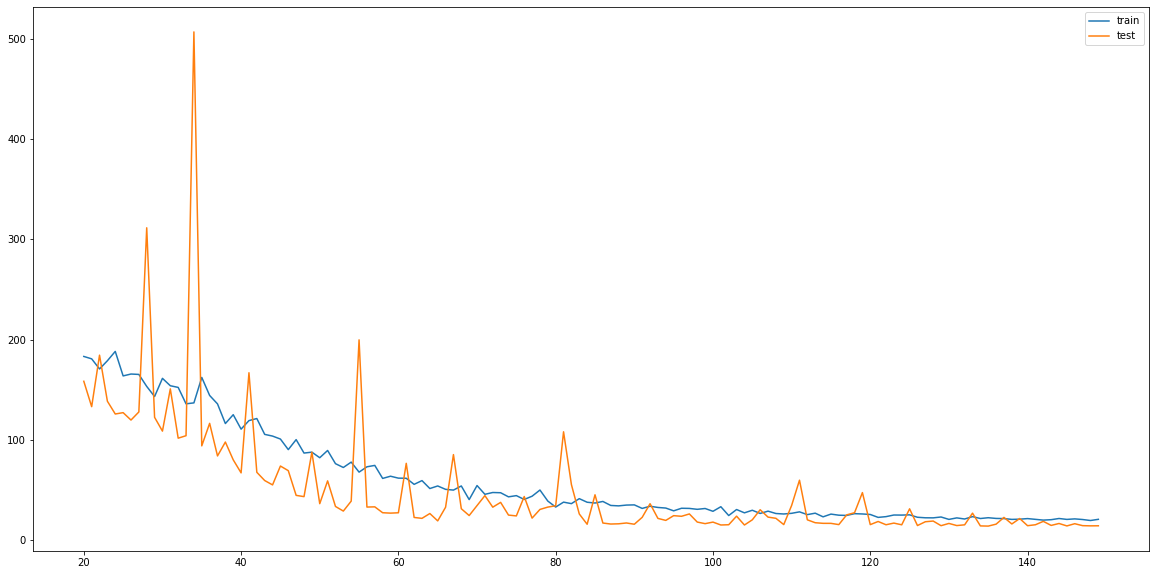

In [ ]:
mynet = Network()

mynet.dense(64, relu, 24)
mynet.dropout(0.4)
mynet.dense(64, relu)
mynet.dropout(0.8)
mynet.dense(64, relu)
mynet.dense(64, relu)
mynet.dense(1, linear)

dataset = make_dataset()
epochs = 150

opt_args = ('rmsprop', {'decay_rate':0.99})
L1 = {'mode':'L1', 'lambda':10}
L2 = {'mode':'L2', 'lambda':25}

mynet.reset()
mynet.learn(huber, epochs, dataset, reg=None, batch_size=16,
            eta=0.01, opt_args=opt_args, verbos=0)
print(mynet.report['train_loss'][-1], mynet.report['test_loss'][-1])
plt.plot(np.arange(20, epochs), mynet.report['train_loss'][20:],
         label="train")
plt.plot(np.arange(20, epochs), mynet.report['test_loss'][20:],
         label="test")

plt.legend()
plt.show()
# 15.437905190191724 16.334320533293017 No Reg
# 14.637040109417876 14.362402623562605 L1 10
# 12.412600410057292 13.814274131891665 L2 25
# 20.92074481936391 14.48625840279653 Dropout 0.4 0.8